In [1]:
import tensorflow as tf
import tensorflow_io as tfio

import numpy as np
import glob
from matplotlib import pyplot as plt

In [2]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        if name == 'L':
            plt.imshow(image, cmap='gray')
        else:
            plt.imshow(image)
    plt.show()

In [3]:
images = glob.glob('data/images/Test/*.jpg')

# Simple AutoEncoder Inference

In [14]:
model = tf.keras.models.load_model('model/color_autoencode.h5', compile=False)

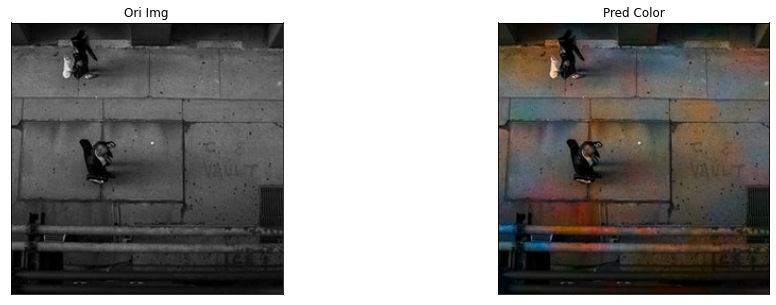

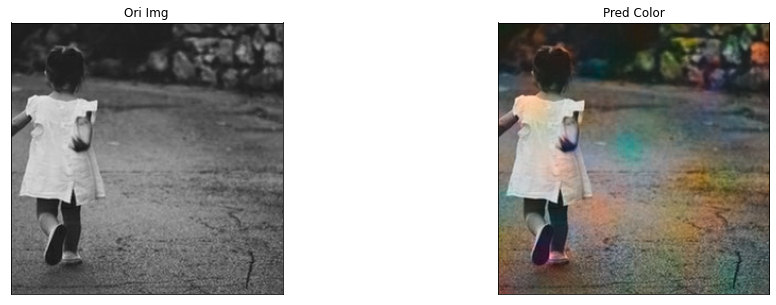

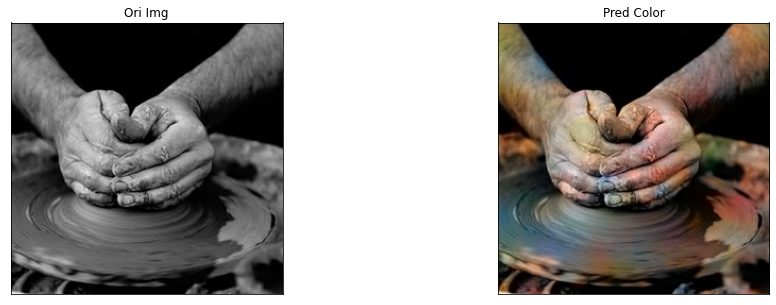

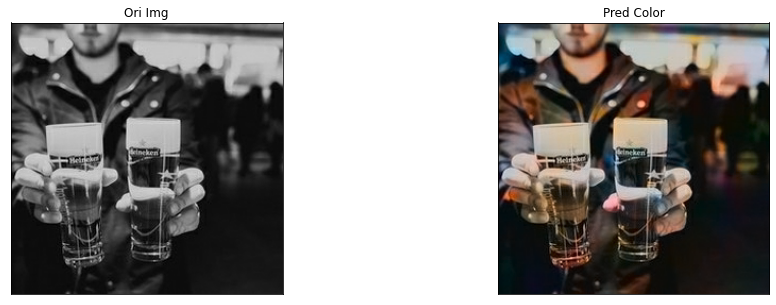

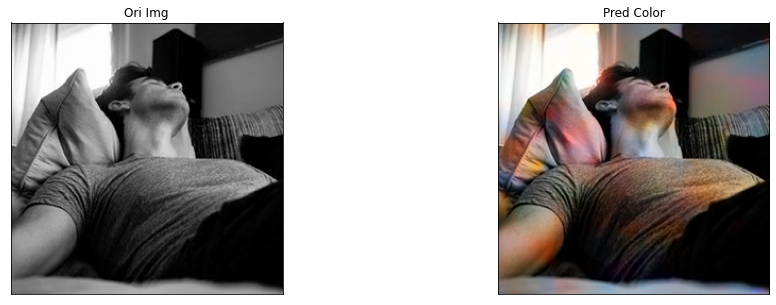

<Figure size 432x288 with 0 Axes>

In [16]:
for image in np.random.choice(images, size=5):
    img = tf.io.decode_jpeg(tf.io.read_file(image))
    
    img_norm = tf.cast(img, tf.float32)
    img_norm = img_norm / 255.
    lab_img = tfio.experimental.color.rgb_to_lab(img_norm)
    l_img = lab_img[:, :, 0]
    
    ab_pred = model.predict(np.expand_dims(l_img, axis=0))
    lab_img_recon = np.zeros((256, 256, 3))
    lab_img_recon[:, :, 0] = l_img
    lab_img_recon[:, :, 1:] = np.squeeze(ab_pred * 128, axis=0)
    
    visualize(
        ori_img=img, pred_color=tf.cast(tfio.experimental.color.lab_to_rgb(lab_img_recon)* 255, tf.uint8) 
    )
    
plt.tight_layout()

# Transfer Learning Encoder

In [8]:
from efficientnet.tfkeras import EfficientNetB3

In [9]:
effnet_model = EfficientNetB3(weights='imagenet', include_top=True)
model = tf.keras.models.load_model('model/effnet_colorizer.h5', compile=False)

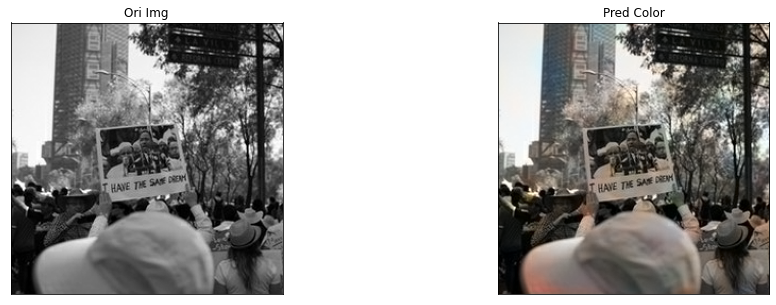

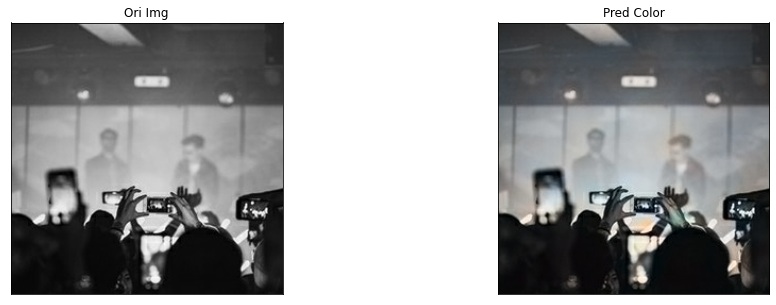

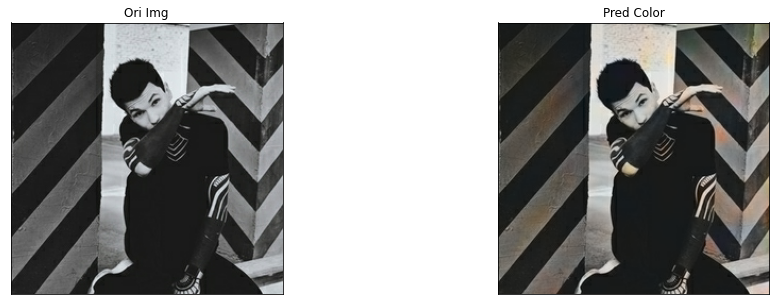

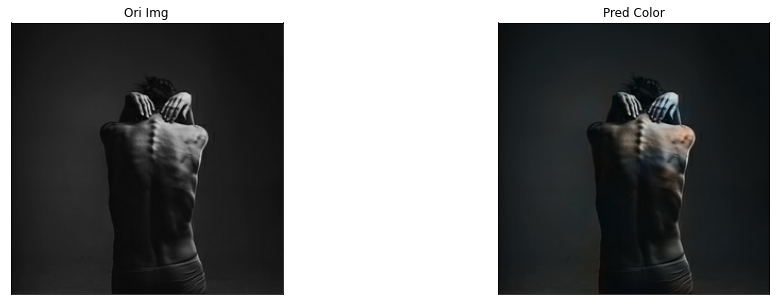

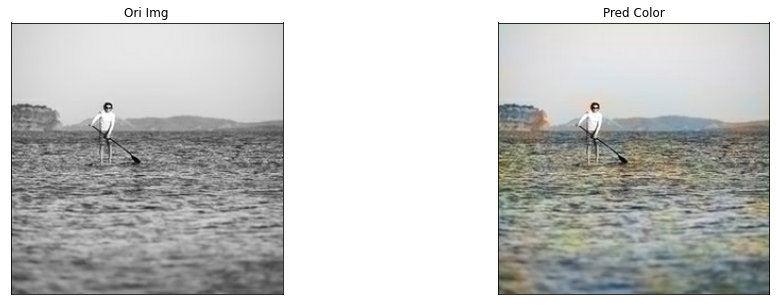

In [11]:
for image in np.random.choice(images, size=5):
    img = tf.io.decode_jpeg(tf.io.read_file(image))
    
    img_norm = tf.cast(img, tf.float32)
    img_norm = img_norm / 255.
    lab_img = tfio.experimental.color.rgb_to_lab(img_norm)
    l_img = lab_img[:, :, 0]
    
    img_resized = tf.image.resize(img, (300, 300))
    img_resized = img_resized / 255.
    embeddings = effnet_model.predict(tf.expand_dims(img_resized, axis=0))
    
    pred_ab = model.predict([tf.expand_dims(l_img, axis=0), embeddings])
    
    lab_img_reconstru = np.zeros((256, 256 ,3))
    lab_img_reconstru[:, :, 0] = l_img
    lab_img_reconstru[:, :, 1:] = np.squeeze(pred_ab, axis=0) * 128
    
    visualize(
        ori_img=img, pred_color=tf.cast(tfio.experimental.color.lab_to_rgb(lab_img_reconstru) * 255, tf.uint8)
    )